# Amazon Musical Instrument Reviews

I will first download the training and testing data and unzip the files.

In [ ]:
!wget http://34.82.108.37/amazonReviewsTest.csv

--2023-04-28 07:43:27--  http://34.82.108.37/amazonReviewsTest.csv
Connecting to 34.82.108.37:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4240573 (4.0M) [application/octet-stream]
Saving to: ‘amazonReviewsTest.csv.1’

amazonReviewsTest.c 100%[===================>]   4.04M  --.-KB/s    in 0.03s   

2023-04-28 07:43:27 (138 MB/s) - ‘amazonReviewsTest.csv.1’ saved [4240573/4240573]



In [ ]:
!wget http://34.82.108.37/amazonReviewsTrain.csv.zip

--2023-04-28 07:43:34--  http://34.82.108.37/amazonReviewsTrain.csv.zip
Connecting to 34.82.108.37:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39456705 (38M) [application/zip]
Saving to: ‘amazonReviewsTrain.csv.zip.1’

amazonReviewsTrain. 100%[===================>]  37.63M  91.9MB/s    in 0.4s    

2023-04-28 07:43:34 (91.9 MB/s) - ‘amazonReviewsTrain.csv.zip.1’ saved [39456705/39456705]



In [ ]:
!unzip /content/amazonReviewsTrain.csv.zip

Archive:  /content/amazonReviewsTrain.csv.zip
replace amazonReviewsTrain.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

I have an idea to classify the data using embedding so I will need to train and test on the reviewText and the rating columns. I will predict if a user had a positive, neutral, or negative rating.

In [ ]:
import keras
keras.__version__

'2.12.0'

I will assign the data to variables with the training data having the reviewText and the ratings, while the test data only has the reviewText. We will predict the rating for the test data later.

In [ ]:
import pandas as pd
train = pd.read_csv('amazonReviewsTrain.csv')
train = train[['reviewText', 'rating']]
test = pd.read_csv('amazonReviewsTest.csv')
test = test[['reviewText']]
train

<ipython-input-23-add5d44d87e1>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('amazonReviewsTrain.csv')


,reviewText,rating
0,Have 30 of these in operation great lights,positive
1,"Good replacement. I prefer my Rovner L5, but ...",positive
2,My son & band teacher loves it. Really nice. B...,positive
3,This was a gift for a friend who is a fan of t...,positive
4,Wish it would attach to my violin a little eas...,positive
...,...,...
221387,Still hard to beat D'Addario. Hope they keep i...,positive
221388,Ortofon hits the nail right on the head with t...,positive
221389,This is my absolute favorite guitar strap amon...,positive
221390,nice,positive


I need to make sure the reviewText is of type string and then I will change the ratings to integers to make predicting easier. I got an error about changing the type of the text so I will also make changes to the text in the test data for later use.

In [ ]:
train.reviewText = train.reviewText.astype(str)
train_text = train.reviewText
test.reviewText = train.reviewText.astype(str)
test_text = test.reviewText
train_label = train.rating
def condition(x):
    if x=='positive':
        return 2
    elif x=='neutral':
        return 1
    else:
        return 0
train_label =  train['rating'].apply(condition)
train_label

0         2
1         2
2         2
3         2
4         2
         ..
221387    2
221388    2
221389    2
221390    2
221391    2
Name: rating, Length: 221392, dtype: int64

I am going to use the top 20,000 most common words and cut the reviews after 100 words so that as much of the words in the review can be used and I can get more accurate predictions.

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = 20000)
#build the word index
tokenizer.fit_on_texts(train_text)
# now convert the words to integers
train_sequences = tokenizer.texts_to_sequences(train_text)
#build the word index
tokenizer.fit_on_texts(test_text)
# now convert the words to integers
test_sequences = tokenizer.texts_to_sequences(test_text)

train_sequences[0]

[18, 534, 9, 25, 13, 2199, 22, 570]

In [ ]:
from keras.utils import pad_sequences
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 100

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
trainingNum = pad_sequences(train_sequences, maxlen=maxlen)
testingNum = pad_sequences(test_sequences, maxlen=maxlen)

trainingNum[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,   18,  534,    9,   25,   13, 2199,   22,
        570], dtype=int32)

Now I will split the training data into training and testing.

In [ ]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(trainingNum, train_label, test_size = 0.2, random_state=42)
test_labels

5028      0
133605    2
182161    2
137498    2
122233    1
         ..
45935     2
5691      2
83947     2
214291    1
8033      1
Name: rating, Length: 44279, dtype: int64

Since I am looking for more than 2 categories, I need to make my data categorical rather than binary.

In [ ]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Here I will create a model with the embedding layer

In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras import layers
from keras.layers import Flatten, Dense, Embedding

vocabulary_size = 20000
embedding_size = 100
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(vocabulary_size, embedding_size, input_length=maxlen))
model.add(Flatten())
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          2000000   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 3)                 30003     
                                                                 
Total params: 2,030,003
Trainable params: 2,030,003
Non-trainable params: 0
_________________________________________________________________


The model now needs to be fit. I will use 15 epochs to get a decent accuracy while minimizing the time the system takes to run all the steps.

In [ ]:
history = model.fit(
      train_features, train_labels,
      steps_per_epoch=100,
      epochs=5,
      validation_split=0.2,
      validation_steps=50)

Epoch 1/5
100/100 [==============================] - 12s 117ms/step - loss: 0.4714 - accuracy: 0.8601 - val_loss: 0.4259 - val_accuracy: 0.8649
Epoch 2/5
100/100 [==============================] - 9s 94ms/step - loss: 0.3939 - accuracy: 0.8690 - val_loss: 0.3789 - val_accuracy: 0.8688
Epoch 3/5
100/100 [==============================] - 7s 66ms/step - loss: 0.3582 - accuracy: 0.8757 - val_loss: 0.3540 - val_accuracy: 0.8761
Epoch 4/5
100/100 [==============================] - 5s 46ms/step - loss: 0.3363 - accuracy: 0.8819 - val_loss: 0.3416 - val_accuracy: 0.8782
Epoch 5/5
100/100 [==============================] - 4s 42ms/step - loss: 0.3199 - accuracy: 0.8867 - val_loss: 0.3288 - val_accuracy: 0.8823


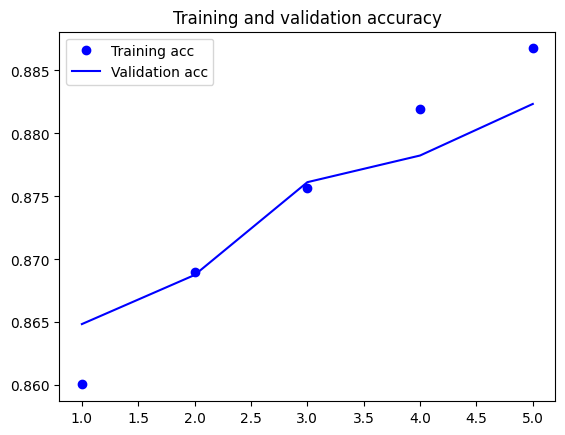

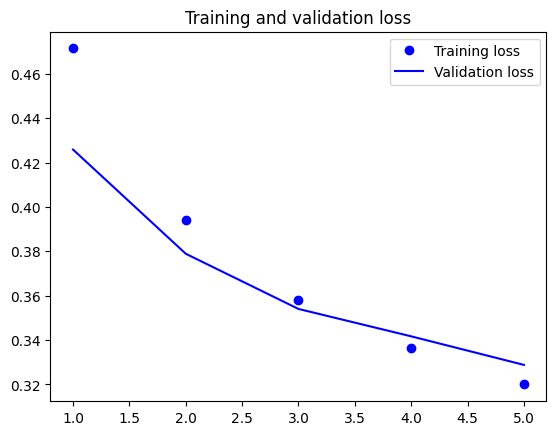

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc, = model.evaluate(test_features, test_labels)
print("Accuracy %f    Loss: %f" % (test_acc, test_loss))

1384/1384 [==============================] - 3s 2ms/step - loss: 0.3236 - accuracy: 0.8847
Accuracy 0.884731    Loss: 0.323589


The accuracy is at 89% so now we will use this model to predict on our test data.

In [ ]:
import numpy as np
predictions = np.argmax(model.predict(testingNum), axis=-1)

313/313 [==============================] - 0s 1ms/step


Now that I have predicted on the test data and ensured that the model predicted the classes using argmax, I can revert the integers back to strings and write them to the amazonReviewsPredictions file.

In [ ]:
with open('amazonReviewsPredictions.txt', 'w') as f:
    for rating in predictions:
        if rating == 0:
            f.write('negative\n')
        elif rating == 1:
            f.write('neutral\n')
        else:
            f.write('positive\n')

This function will make sure I have the data in the proper format.

In [ ]:
def test():
  i = 0
  answers = ['negative', 'neutral', 'positive']
  with open('amazonReviewsPredictions.txt', 'r') as outfile:
    lines = outfile.readlines()
    for line in lines:
        if line.strip() not in answers:
          return("invalid entry line %i" % (i))
        i += 1
    if i != 10000:
      return ("incorrect number of lines")
    else:
      return ("file looks ok")
test()

'file looks ok'